In [1]:
import os                                               #os interface library 
import requests                                         #HTTP requests library
import pandas as pd                                     #panda library
from dotenv import load_dotenv                          #dotenv library to read keys and secrect key for api
import alpaca_trade_api as trade_api                     #Alpaca library
from MCForecastTools import MCSimulation                #Monta Carlos simulation apis
import json                                             #JSON library ro work with JSON objects
from datetime import date                               #Data-Time library

#set the backend of matplotlib to the 'inline' backend 
%matplotlib inline 
# Load .env enviroment variables
load_dotenv()
True
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')
    return alpaca
    

In [2]:
# # Function for retrieving data relative to tickers/portfolio
def portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                        
    today = pd.Timestamp(today, tz="America/New_York").isoformat()  
    timeframe ='1Day'
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df
    portfolio.index = portfolio.index.date
    return portfolio
# function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = portfolio_data(symbol)
    symbol = bench_mark[['close']].rename(columns = {'close': symbol})
    return symbol
# function to seperate the required data :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)
    closing_price = ticker[['close']]
    closing_price = closing_price.rename(columns={'close' : 'close'})
    return closing_price
# function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()
    data_cumulative = (1+data_returns).cumprod()
    return data_cumulative
# function for equally weghting stocks:
def equal_weights(data):
    weights = []
    for i in range(0,len(portfolio.columns)):
        w = 1/len(portfolio.columns)
        weights.append(w)
    return weights   


In [3]:
alpaca = setting_api()
tickers = ['APD', 'APH', 'RACE', 'TEL', 'IFF', 'GLW']
portfolio = portfolio_data(tickers)
portfolio.head()


,open,high,low,close,volume,trade_count,vwap,symbol
2017-04-13,135.33,135.5800,134.17,134.30,626943,7518,134.705681,APD
2017-04-17,134.78,135.8950,134.42,135.86,1092375,11416,135.497295,APD
2017-04-18,135.04,136.0200,134.72,135.27,701020,10116,135.259170,APD
2017-04-19,135.73,136.0399,134.78,134.96,577819,7170,135.166924,APD
2017-04-20,135.62,137.3400,135.20,136.90,985329,10779,136.676759,APD


In [4]:
apd =format_data('APD')
aph =format_data('APH')
race=format_data('RACE')
tel=format_data('TEL')
iff=format_data('IFF')
glw=format_data('GLW')
apd.head()

,close
2017-04-13,134.30
2017-04-17,135.86
2017-04-18,135.27
2017-04-19,134.96
2017-04-20,136.90


In [5]:
portfolio = pd.concat([apd,aph,race,tel,iff,glw],axis =1,keys = ['APD','APH','RACE','TEL','IFF','GLW'])
portfolio.head()

,APD,APH,RACE,TEL,IFF,GLW
,close,close,close,close,close,close
2017-04-13,134.30,68.65,70.63,71.93,131.94,26.32
2017-04-17,135.86,69.53,71.32,72.77,133.02,26.54
2017-04-18,135.27,69.96,70.59,73.08,134.07,26.89
2017-04-19,134.96,70.12,71.26,73.18,134.53,26.86
2017-04-20,136.90,70.82,71.40,74.12,135.80,27.11


In [6]:
spy = bench_mark('SPY')
spy.head()

,SPY
2017-04-13,232.51
2017-04-17,234.57
2017-04-18,233.87
2017-04-19,233.44
2017-04-20,235.34


<AxesSubplot:>

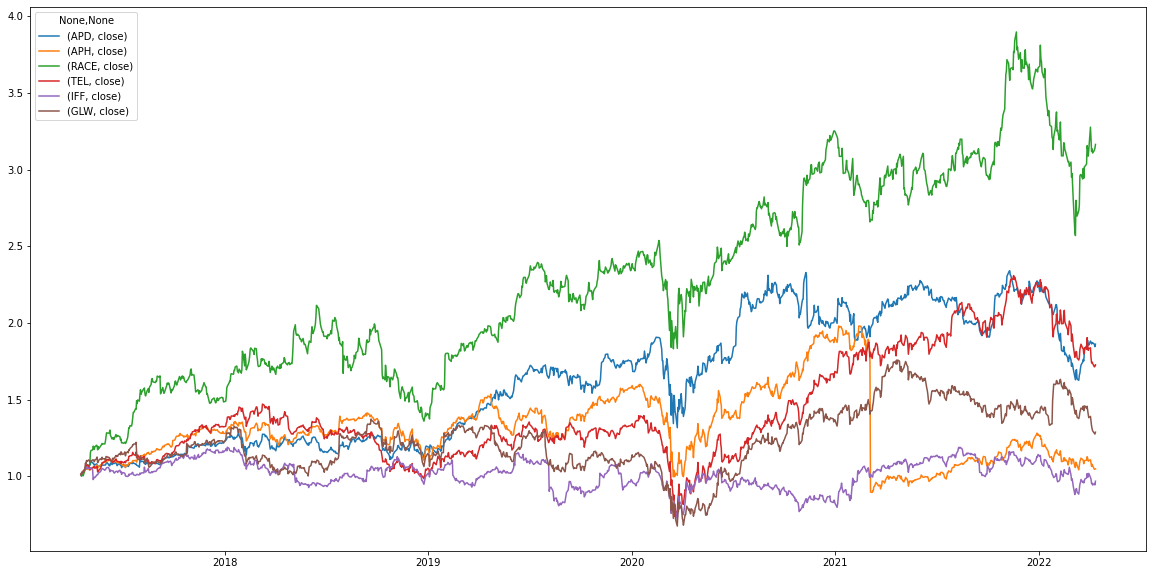

In [7]:
spy_cumulative = cumulative_returns(spy)
portfolio_cumulative = cumulative_returns(portfolio)
portfolio_cumulative.plot(figsize = (20,10))

<AxesSubplot:>

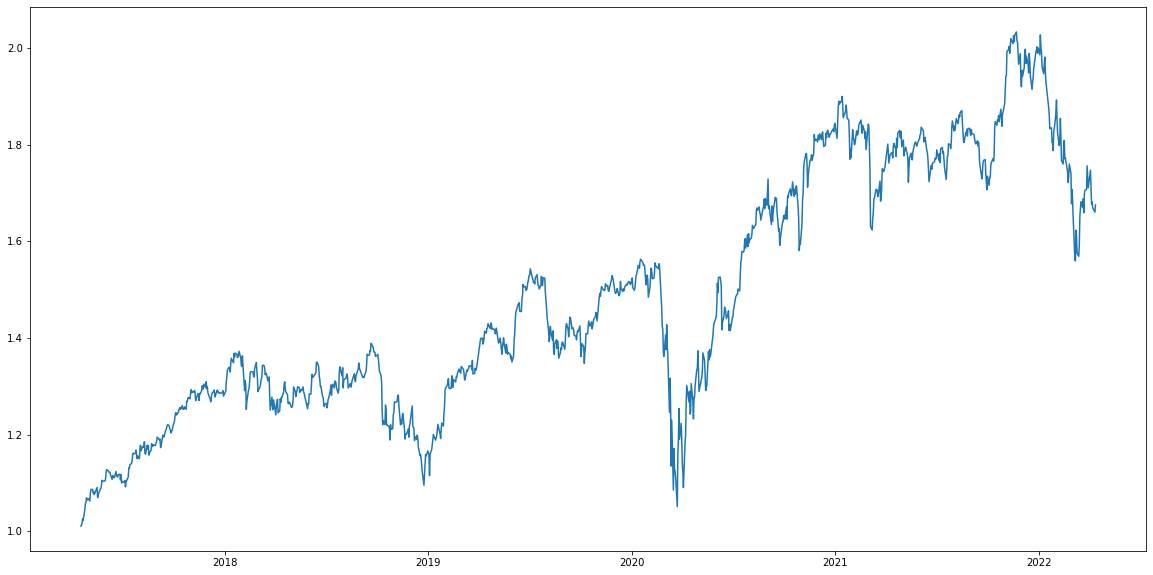

In [8]:
weights = equal_weights(portfolio)
portfolio_price_action = portfolio_cumulative.dot(weights)
portfolio_price_action.plot(figsize = (20,10))

In [9]:
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()

<AxesSubplot:>

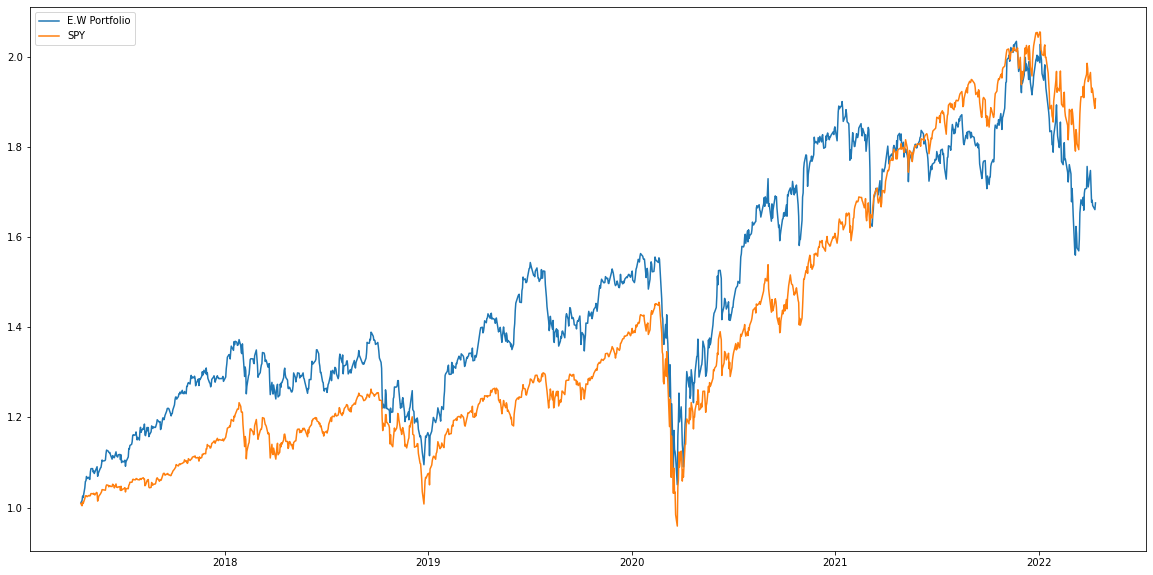

In [10]:
comparison = comparison.rename(columns = {0:'E.W Portfolio'})
comparison.plot(figsize = (20,10))

In [11]:
?MCSimulation

Init signature:
MCSimulation(
    portfolio_data,
    weights='',
    num_simulation=1000,
    num_trading_days=252,
)
Docstring:     
A Python class for runnning Monte Carlo simulation on portfolio price data. 

...

Attributes
----------
portfolio_data : pandas.DataFrame
    portfolio dataframe
weights: list(float)
    portfolio investment breakdown
nSim: int
    number of samples in simulation
nTrading: int
    number of trading days to simulate
simulated_return : pandas.DataFrame
    Simulated data from Monte Carlo
confidence_interval : pandas.Series
    the 95% confidence intervals for simulated final cumulative returns
    
Init docstring:
Constructs all the necessary attributes for the MCSimulation object.

Parameters
----------
portfolio_data: pandas.DataFrame
    DataFrame containing stock price information from Alpaca API
weights: list(float)
    A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
num_simulation: int
    Number 

In [12]:
sim_ew = MCSimulation(
    portfolio,
    weights=equal_weights(portfolio),
    num_simulation=1000,
    num_trading_days=252,
)

In [13]:
sim_ew.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Zahra\Desktop\Responsible_Investor\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993807,0.998180,1.004986,1.005646,0.993351,0.976368,1.006746,1.003730,1.012448,1.001254,...,1.009321,0.992914,0.995670,1.004184,1.001259,1.000136,0.992818,1.003626,0.997910,1.001314
2,0.980906,0.986404,1.001260,1.000672,0.986884,0.975751,1.012338,0.995672,1.009810,1.002647,...,1.011257,0.998673,0.998082,0.997395,0.988394,1.013034,0.998106,1.015227,0.997358,1.017192
3,0.975936,0.964421,0.998302,1.008432,0.980246,0.968124,1.007517,1.006313,1.021851,1.001344,...,1.001783,0.992444,1.002677,1.003627,0.990347,1.019655,1.009216,1.027890,1.002410,1.000451
4,0.975556,0.969243,0.985763,1.006225,0.966777,0.981711,1.013332,1.001882,1.015766,0.998142,...,0.990358,0.988061,1.001396,1.013341,0.989369,1.008982,1.019001,1.025479,1.001014,1.007333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.983895,1.079588,1.098083,1.220389,1.063603,1.120058,1.514233,1.130170,1.272841,1.186389,...,1.142262,1.474661,1.342979,1.114034,1.011186,1.496825,1.006845,0.944722,1.038806,1.360809
249,0.982045,1.070123,1.097879,1.212898,1.053018,1.117640,1.520508,1.134243,1.280006,1.192306,...,1.127796,1.461452,1.360279,1.117393,1.005474,1.488402,1.007102,0.943665,1.041888,1.380736
250,0.980870,1.077265,1.097982,1.205495,1.073293,1.120223,1.529967,1.143829,1.291324,1.185606,...,1.138863,1.435401,1.354396,1.110565,0.999463,1.504317,1.007538,0.926619,1.045441,1.389599
251,0.981161,1.079094,1.103584,1.202802,1.078566,1.113223,1.513252,1.155273,1.274257,1.186535,...,1.140987,1.436094,1.387389,1.103409,1.006327,1.502761,1.001171,0.940328,1.048319,1.375045


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days.'}>

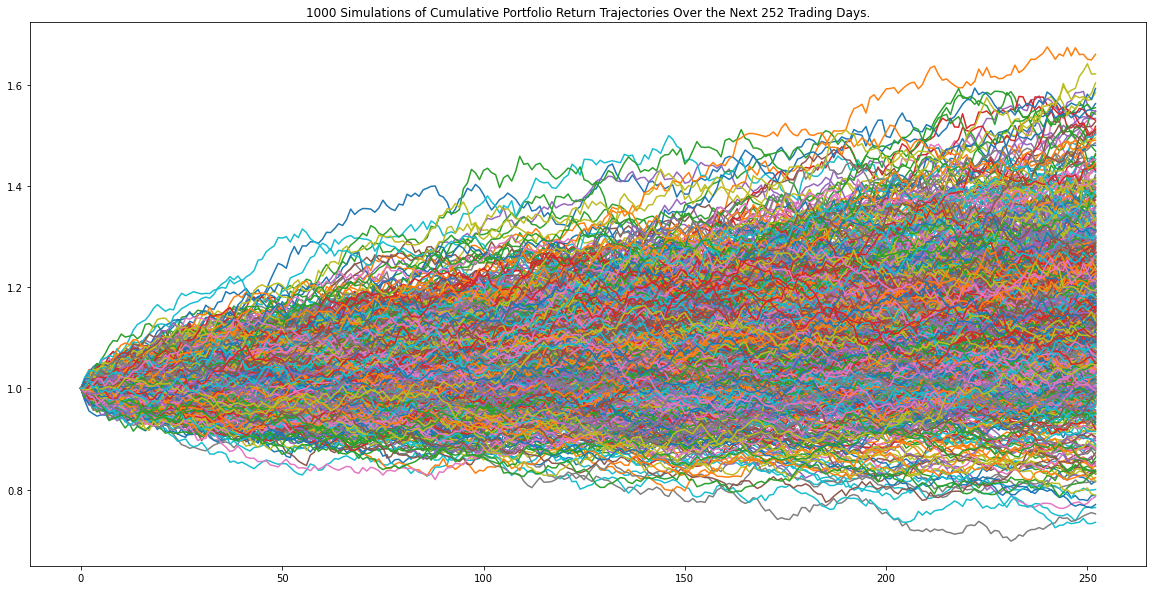

In [16]:
sim_ew.plot_simulation()